# Notebook de test des données lapi post-traitees

In [214]:
%load_ext autoreload
%autoreload 
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import Connexion_Transfert as ct
import donnees_posttraitees as t
import graphs as g
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)
import os, math, re
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. import des données, traitement de mise en forme
## 1.1 Import
Les données sont importées sur la période du 24/01/19 au 23/02/19, sur laquelle il n'y a pas de manque de données à priori

In [2]:
%time df_passages, df_plaques, df_immat=t.ouvrir_fichier_lapi_final('2019-01-31 00:00:00','2019-02-11 23:59:59')

Wall time: 1min 20s


## 1.2. Suppression des doublons

### 1.2.1 Doublons

In [3]:
%time df_passages=t.supprimer_doublons(df_passages)

### 1.2.2 passages proches

In [211]:
%time groupe_pl_rappro, groupe_pl=t.passages_proches(df_passages4)

Wall time: 48 s


In [212]:
groupe_pl_rappro.head(5)#.to_csv(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\lapi_passages_proches.csv')

,camera_id,created,state,fiability,erreur_tps_passage,liste_passag_faux,liste_created_faux,fiability_faux
immat,,,,,,,,
001b3fc1839070936df83443270d62a53becc9db,"(4, 10, 5, 6, 3)","(2019-01-31 09:49:36, 2019-01-31 09:51:11, 2019-01-31 10:01:30, 2019-02-11 02:56:16, 2019-02-11 03:08:05)",FR,"(99, 99, 99, 99, 99)",True,"(4, 10)","(2019-01-31 09:49:36, 2019-01-31 09:51:11)","(99, 99)"
0028f8fa0d1dc22e6eb4c1c57d0caeb1efb0fbfb,"(10, 4, 5, 11, 12, 6, 3)","(2019-02-01 06:33:08, 2019-02-01 06:34:47, 2019-02-01 06:47:25, 2019-02-01 07:13:12, 2019-02-04 15:58:51, 2019-02-04 16:19:22, 2019-02-04 16:32:22)",PL,"(99, 99, 99, 99, 89, 79, 99)",True,"(10, 4)","(2019-02-01 06:33:08, 2019-02-01 06:34:47)","(99, 99)"
005728f228714ee3a531f3b6cae08f9c8c2f21e7,"(3, 9, 10, 4, 7, 8, 6, 3, 4, 5, 6, 3, 4, 12, 3, 9, 4, 10, 7, 8, 6, 3, 4, 3, 9, 4, 10, 7, 8, 7, 8, 6, 3, 4, 3, 9, 4, 10, 5, 6, 3, 4, 3, 9)","(2019-01-31 03:07:45, 2019-01-31 03:18:46, 2019-01-31 08:01:01, 2019-01-31 08:11:26, 2019-01-31 09:56:02, 2019-01-31 14:46:09, 2019-02-01 05:14:30, 2019-02-01 05:26:52, 2019-02-01 06:58:54, 2019-02-01 07:12:15, 2019-02-01 08:22:55, 2019-02-01 08:49:18, 2019-02-01 10:15:13, 2019-02-01 15:19:31, 2019-02-04 05:32:59, 2019-02-04 05:44:15, 2019-02-04 08:56:50, 2019-02-04 09:07:28, 2019-02-04 10:41:33, 2019-02-04 15:51:48, 2019-02-05 04:38:55, 2019-02-05 04:50:53, 2019-02-05 06:38:37, 2019-02-06 05:34:44, 2019-02-06 05:46:25, 2019-02-06 09:11:02, 2019-02-06 09:22:20, 2019-02-07 04:45:32, 2019-02-07 09:49:13, 2019-02-07 11:16:00, 2019-02-07 14:38:11, 2019-02-08 04:16:42, 2019-02-08 04:28:55, 2019-02-08 06:02:46, 2019-02-08 07:55:51, 2019-02-08 08:19:29, 2019-02-08 12:48:02, 2019-02-08 12:58:30, 2019-02-08 12:59:39, 2019-02-08 14:00:29, 2019-02-08 14:12:31, 2019-02-08 15:46:47, 2019-02-11 04:20:11, 2019-02-11 04:30:08)",FR,"(99, 99, 99, 99, 99, 99, 99, 89, 99, 99, 99, 99, 99, 99, 99, 99, 89, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 89, 99, 99, 99, 68, 99, 99, 89, 99, 99, 99, 99, 89, 99, 99)",True,"(10, 5)","(2019-02-08 12:58:30, 2019-02-08 12:59:39)","(99, 99)"
005a9f27ff36441aab778af90e3d145f0d12cf60,"(4, 18, 9, 19, 18, 3, 9, 3, 3, 6, 10, 10, 4, 4, 7, 18, 3, 18, 3, 4, 3, 3, 8, 12, 6, 6, 10, 6, 18, 12, 12, 4, 5, 6, 3, 10, 3, 3, 18, 3, 13, 13, 18, 3, 8, 9, 12, 4, 3, 4, 5, 15, 12, 18, 6, 12, 7, 3, 18, 12, 5)","(2019-01-31 09:03:37, 2019-01-31 09:03:59, 2019-01-31 09:09:02, 2019-01-31 10:11:03, 2019-01-31 10:40:07, 2019-01-31 13:36:21, 2019-02-01 08:15:30, 2019-02-01 08:25:27, 2019-02-01 08:46:15, 2019-02-01 09:04:50, 2019-02-01 09:06:34, 2019-02-01 09:18:59, 2019-02-01 13:23:39, 2019-02-01 14:34:16, 2019-02-01 15:28:48, 2019-02-02 15:20:09, 2019-02-03 11:41:58, 2019-02-03 16:10:12, 2019-02-04 04:25:40, 2019-02-04 09:22:44, 2019-02-04 09:40:17, 2019-02-04 10:12:15, 2019-02-04 11:39:46, 2019-02-04 14:30:28, 2019-02-05 11:56:10, 2019-02-05 14:03:54, 2019-02-05 16:13:16, 2019-02-06 07:42:59, 2019-02-06 08:57:28, 2019-02-06 09:56:46, 2019-02-06 11:34:20, 2019-02-06 13:55:23, 2019-02-06 13:59:20, 2019-02-06 16:28:47, 2019-02-07 07:36:04, 2019-02-07 07:50:05, 2019-02-07 10:36:38, 2019-02-07 11:11:06, 2019-02-07 14:10:41, 2019-02-08 08:59:31, 2019-02-08 09:21:07, 2019-02-08 09:27:05, 2019-02-08 11:43:00, 2019-02-08 11:50:02, 2019-02-08 12:07:38, 2019-02-08 12:54:36, 2019-02-08 13:25:37, 2019-02-...",BE,"(79, 89, 79, 89, 99, 79, 88, 99, 88, 79, 99, 89, 89, 99, 79, 88, 88, 99, 99, 89, 89, 99, 89, 99, 89, 88, 99, 89, 79, 79, 99, 89, 99, 89, 79, 89, 88, 89, 89, 99, 99, 89, 89, 99, 89, 89, 88, 99, 89, 79, 79, 79, 88, 79, 99, 79, 89, 79, 88, 89, 99)",True,"(4, 18, 6, 10, 4, 5, 3, 18)","(2019-01-31 09:03:37, 2019-01-31 09:03:59, 2019-02-01 09:04:50, 2019-02-01 09:06:34, 2019-02-06 13:55:23, 2019-02-06 13:59:20, 2019-02-11 15:33:47, 2019-02-11 15:38:17)","(79, 89, 79, 99, 89, 99, 79, 88)"
00622c245465b6ea42b3b03da48b2776f93f8754,"(6, 2, 9, 4, 10, 5, 11)","(2019-02-07 12:26:06, 2019-02-07 14:50:28, 2019-02-07 15:05:28, 2019-02-08 07:30:18, 2019-02-08 07:30:37, 2019-02-08 07

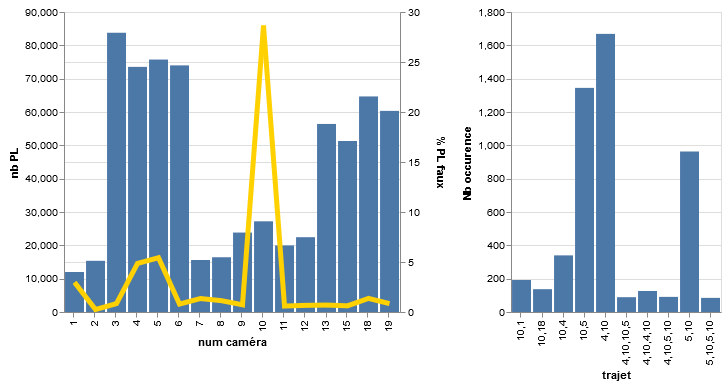

In [215]:
jointure = g.analyse_passage_proches(groupe_pl_rappro, groupe_pl)
g.graph_passages_proches(jointure, groupe_pl_rappro)

## 1.3 Ajout de l'attribut de différenciation VL / PL

In [4]:
%time df_passages2=t.affecter_type(df_passages,df_immat)

Wall time: 4min 1s


In [5]:
%time df_passages3=t.affecter_type_nuit(df_passages2,df_immat)

Wall time: 21.8 s


In [6]:
len(df_passages2.loc[df_passages2['l']==1])

688958

In [7]:
len(df_passages3.loc[df_passages3['l']==1])

692674

***ATTENTION : ENCORE 18764 IMMATRCULATION COURTE PRESENTES DANS TE_PASSAGES ET NON PRENSENTES DANS TE_PLAQUES_COURTE :***

In [69]:
df_passages2.loc[df_passages2.immatriculation.isna()].merge(df_plaques, left_on='immat', right_on='chiffree').to_csv(
    r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\immatriculation_manquante.csv')

***ATTENTION : PLUS DE 1M DE PASSAGES SANS VALEUR DE VL_TOT ou PL_TOT ou VUL_TOT :***

In [183]:
#nb de passages avec un type inconnu
passages_type_inconnu=(df_passages3.loc[df_passages3['l']==-1]).reset_index()#.head(20)

In [184]:
#passages inconnu avec une fiabilite superieure a 75 sur cam autre que 1ou2 et fiab > 35 sr cam 1 et 2
passages_type_inconnu_fiab_sup75=(passages_type_inconnu.loc[((passages_type_inconnu['fiability']>75) & (~passages_type_inconnu['camera_id'].isin([1,2]))) |
                                                            ((passages_type_inconnu['fiability']>35) & (passages_type_inconnu['camera_id'].isin([1,2])))])

In [185]:
len(passages_type_inconnu_fiab_sup75)

232939

In [167]:
groupe=(passages_type_inconnu_fiab_sup75.set_index('created').sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 
                                                                                 'created':lambda x: tuple(x), 
                                                                                 'state': lambda x : set(tuple(x))}))

In [168]:
groupe_filtre=groupe.loc[groupe.apply(lambda x: (all((pd.to_datetime(e).hour>19 or pd.to_datetime(e).hour<7) for e in x['created'])) &
                        (x['camera_id'] in t.liste_complete_trajet.cameras.tolist()) & (len(x['state'])==1) & 
                        (x['state']!=set(['FR',])) ,axis=1)].copy()

In [169]:
groupe_filtre=groupe_filtre.loc[~groupe_filtre.apply(lambda x: [(a) for a in x['state']]==['  '],axis=1)]
groupe_filtre

,camera_id,created,state
immat,,,
001e325735145d38489dc2bec097cc10d3294386,"(12, 6, 3, 18)","(2019-02-10 00:45:53, 2019-02-10 01:07:47, 2019-02-10 01:20:05, 2019-02-10 01:39:53)",{NL}
00211a77de4f1d952d0384090f231efd091e4805,"(19, 5)","(2019-02-02 21:19:14, 2019-02-02 21:42:47)",{ES}
0028aa39418784ac9abe4f9cb52dd8d732ec58aa,"(6, 3, 18)","(2019-02-05 21:33:17, 2019-02-05 21:44:15, 2019-02-05 22:00:16)",{NL}
00800ead14cca17cea7df922087f1f0fd35af0e7,"(19, 5)","(2019-02-07 22:07:14, 2019-02-07 22:36:05)",{PL}
009f5722e10075e77b58bd067f419d116c3c272f,"(19, 4, 5)","(2019-02-06 20:54:24, 2019-02-06 21:11:11, 2019-02-06 21:26:19)",{PL}
012454c49cc65806d25a0d3641f3e899d1948465,"(12, 6, 3, 18)","(2019-02-09 03:16:46, 2019-02-09 03:26:52, 2019-02-09 03:36:49, 2019-02-09 03:52:01)",{NL}
012f57273420b5ff3dc07881350e6ce368de9fbc,"(12, 6, 3, 18)","(2019-02-09 01:34:09, 2019-02-09 01:45:03, 2019-02-09 01:54:23, 2019-02-09 02:19:40)",{PT}
0181bd66684bad32c89ff81f0077edf6a426be16,"(6, 3, 18)","(2019-02-01 05:01:51, 2019-02-01 05:14:28, 2019-02-01 06:04:26)",{BE}
021c276fb5eeeba9ff761ee23454c51635b22eef,"(6, 3, 18)","(2019-02-08 22:23:02, 2019-02-08 22:34:45, 2019-02-08 22:53:40)",{BE}


In [141]:
df_passages2.loc[df_passages2['immat'].isin(groupe_filtre.index.tolist()),'l']=1

In [18]:
#premier exemple : cas de vl_total et vul_total rempli : il faut modifier la condition et ne pas interroger les attributs _total mais bien les attributs source
df_immat.loc[df_immat['immatriculation']=='b86a39d29995c8839d934989cc90d9a48f114ca4']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2549004,1914544,b86a39d29995c8839d934989cc90d9a48f114ca4,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,128,32,360480,-1


In [19]:
#deuxieme exemple : cas de aucun attributs rempli : on laisse à -1
df_immat.loc[df_immat['immatriculation']=='cb12765d8b9f8a6d8d11e7ea1a384272466c2324']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2578051,2109090,cb12765d8b9f8a6d8d11e7ea1a384272466c2324,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,262144,-1


In [24]:
#3eme exemple : cas de vl_total et vul_total rempli : véhicules étranger passés de nuit
df_immat.loc[df_immat['immatriculation']=='4a2c8c1847e2bc4143e2dc51636eef039182203c']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2643381,770228,4a2c8c1847e2bc4143e2dc51636eef039182203c,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,262144,-1


In [29]:
#4eme exemple : cas de 9l_total et vul_total rempli : véhicules étranger passés de nuit
df_immat.loc[df_immat['immatriculation']=='4a2c8c1847e2bc4143e2dc51636eef039182203c']

,id,immatriculation,pl_siv,pl_3barriere,pl_2barriere,pl_mmr75,pl_1barriere,pl_3camera,pl_2camera,pl_1camera,vul_siv,vul_mmr75,vl_siv,vl_mmr75,vl_3camera,vl_2camera,vl_1camera,pl_total,vul_total,vl_total,mot,type_veh
2643381,770228,4a2c8c1847e2bc4143e2dc51636eef039182203c,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,262144,-1


In [173]:
#localisation dans le fichier des passages
df_passages3.loc[df_passages3['immat']=='4a2c8c1847e2bc4143e2dc51636eef039182203c']

,index,camera_id,immat,fiability,l,state,id
created,,,,,,,
2019-01-31 00:11:02,1585270,6,4a2c8c1847e2bc4143e2dc51636eef039182203c,99,1,ES,1014857
2019-01-31 00:21:39,1591264,3,4a2c8c1847e2bc4143e2dc51636eef039182203c,79,1,ES,1014858
2019-01-31 05:40:08,1587520,9,4a2c8c1847e2bc4143e2dc51636eef039182203c,99,1,ES,1014859


# 2. Identifier les trajets de transit

In [8]:
df_passages4=df_passages3.loc[df_passages3['l']==1].copy()

In [9]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-31 00:00:00',11,df_passages4)

date : 2019-01-31 00:00:00 debut_traitement : 2019-05-20 09:33:52.914738
date : 2019-02-01 00:00:00 debut_traitement : 2019-05-20 09:34:54.422937
date : 2019-02-02 00:00:00 debut_traitement : 2019-05-20 09:35:57.869632
date : 2019-02-03 00:00:00 debut_traitement : 2019-05-20 09:36:51.652405
date : 2019-02-04 00:00:00 debut_traitement : 2019-05-20 09:37:33.211683
date : 2019-02-05 00:00:00 debut_traitement : 2019-05-20 09:38:47.950646
date : 2019-02-06 00:00:00 debut_traitement : 2019-05-20 09:40:23.560444
date : 2019-02-07 00:00:00 debut_traitement : 2019-05-20 09:41:44.447666
date : 2019-02-08 00:00:00 debut_traitement : 2019-05-20 09:43:27.702275
date : 2019-02-09 00:00:00 debut_traitement : 2019-05-20 09:45:06.545786
date : 2019-02-10 00:00:00 debut_traitement : 2019-05-20 09:46:31.104019


# 3. Filtrer les trajets selon un temps de parcours

In [22]:
#df des temsp de parcours
dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

***Ici on pourra caracteriser l'impact de la marge***

In [23]:
# df complete avec l'atribut filtre
%time df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

Wall time: 1min 13s


In [13]:
#filtrer le df : 
dico_od_final=df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]
dico_passag_final=t.trajet2passage(dico_od_final,dico_passag)

# 4. Correction des trajets depuis ou vers A660 relatifs à A63

In [14]:
%time df_od_corrige=t.correction_trajet(df_passages2, dico_od_final)

Wall time: 21min 10s


# 5. Extrapolation des trajets non complets

In [15]:
#creer les donnees necessaires
%time df_filtre_A63,df_passage_transit,df_non_transit=t.param_trajet_incomplet('2019-01-28 00:00:00',df_od_corrige,df_passages2,dico_passag)

Wall time: 59.1 s


In [18]:
#trajet de transit incomplet sans filtre sur temps de parcours
%time trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,'2019-01-31 00:00:00',11, df_passages2)

date : 2019-01-31 00:00:00 debut_traitement : 2019-05-16 21:13:50.615971
date : 2019-02-01 00:00:00 debut_traitement : 2019-05-16 21:15:37.979249
date : 2019-02-02 00:00:00 debut_traitement : 2019-05-16 21:16:40.077915
date : 2019-02-03 00:00:00 debut_traitement : 2019-05-16 21:17:03.510637
date : 2019-02-04 00:00:00 debut_traitement : 2019-05-16 21:17:23.077283
date : 2019-02-05 00:00:00 debut_traitement : 2019-05-16 21:18:07.226284
date : 2019-02-06 00:00:00 debut_traitement : 2019-05-16 21:19:00.164409
date : 2019-02-07 00:00:00 debut_traitement : 2019-05-16 21:19:45.334828
date : 2019-02-08 00:00:00 debut_traitement : 2019-05-16 21:20:19.822434
date : 2019-02-09 00:00:00 debut_traitement : 2019-05-16 21:20:45.965237
date : 2019-02-10 00:00:00 debut_traitement : 2019-05-16 21:21:02.941735
Wall time: 7min 28s


In [19]:
#filtrer selon le temps de parcours
trajet_transit_incomplet_filtre_temps=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,t.liste_trajet_incomplet, 15,'incomplet')
#mettre en forme les attributs
trajet_transit_incomplet_filtre_temps=trajet_transit_incomplet_filtre_temps[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
       'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
       'tps_parcours_theoriq', 'filtre_tps']]

In [20]:
#filtrer le df : 
trajet_transit_incomplet_final=trajet_transit_incomplet_filtre_temps.loc[trajet_transit_incomplet_filtre_temps['filtre_tps']==1].copy()
#ajouter l'attribut d'identification des trajets 
trajet_transit_incomplet_final['correction_o_d']=True
trajet_transit_incomplet_final['correction_o_d_type']='extrapole'
#6. Ajouter au df des o_d précédents : 
df_od_final=pd.concat([df_od_corrige,trajet_transit_incomplet_final],sort=False)

# 6. Créer le tableaude matrice o_d

In [21]:
# de base
pd.pivot_table(dico_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,2965,4485,1062,168,NC,8680
A62,1205,NC,168,413,271,1372,3429
A63,3625,106,NC,NC,779,19194,23704
A660,1108,389,NC,NC,525,5105,7127
A89,133,384,1044,596,NC,NC,2157
N10,NC,2412,20275,4386,NC,NC,27073
All,6071,6256,25972,6457,1743,25671,72170


In [22]:
# apres correction des A660 liees a A63
pd.pivot_table(df_od_corrige,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,2965,4753,794,168,NC,8680
A62,1205,NC,198,383,271,1372,3429
A63,3806,123,NC,NC,842,20183,24954
A660,927,372,NC,NC,462,4116,5877
A89,133,384,1147,493,NC,NC,2157
N10,NC,2412,21766,2895,NC,NC,27073
All,6071,6256,27864,4565,1743,25671,72170


In [23]:
# apres extrapolation
pd.pivot_table(df_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,2974,4753,794,168,NC,8689
A62,1205,NC,198,383,271,1373,3430
A63,3806,123,NC,NC,843,20192,24964
A660,927,372,NC,NC,462,4116,5877
A89,133,385,1147,493,NC,NC,2158
N10,NC,2414,21766,2895,NC,NC,27075
All,6071,6268,27864,4565,1744,25681,72193


In [27]:
# O-D apres extrapolation en moyenne sur jour ouvre
df_od_ouvre_final=df_od_final.loc[df_od_final.set_index('date_cam_1').index.dayofweek<5]
pivot_od_jo=pd.pivot_table(df_od_ouvre_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')
pivot_od_jo

In [38]:
pivot_od_jo.applymap(lambda x : x/5 if (isinstance(x,float) or isinstance(x,int)) else 'NC')
#pivot_od_jo.applymap(lambda x : type(x))

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,525.6,716.2,126.4,31.8,NC,1400.0
A62,223.8,NC,36.2,75,50.8,262.4,648.2
A63,560.2,23,NC,NC,139.6,2869.2,3592.0
A660,166.2,70.2,NC,NC,87.6,721.8,1045.8
A89,24.8,73.4,189,90.2,NC,NC,377.4
N10,NC,438.8,3117.8,429.4,NC,NC,3986.0
All,975,1131,4059.2,721,309.8,3853.4,11049.4


# 7. Différeciation Rocade Est-Ouest
>Cette analyse ne concerne que les trajets N10-A63, A10-A63, N10-A660, A10-A660

In [77]:
??t.differencier_rocade

Object `t.differencier_rocade` not found.


In [57]:
pivot_type_rocade

type_rocade,Autre,Est,Ouest,All
o_d,,,,
A10-A63,474,4126,153,4753
A10-A660,159,597,38,794
A63-A10,715,3053,38,3806
A660-A10,248,669,10,927
A660-N10,1184,2892,40,4116
N10-A63,2106,19016,644,21766
N10-A660,589,2205,101,2895
All,5475,32558,1024,39057


# 7. Analyse du nb de VL, PL, PL en transit par heure et par camera 
> Le pb c'est que pour les camera de la Rocade, parfois on les PL n'y sont pas vus, de même pour les chemins extrapoles ou pour ceux corrigés : le passage soit n'existe pas, soit la camera du passage ne correspond pas à la destination finalement utilisées

## 7.1 base : travail sur les données telles que créees

In [48]:
df_vl=df_passages2.loc[df_passages2['l']!=1]
df_pl=df_passages2.loc[df_passages2['l']==1]
#df_passages_transit=t.trajet2passage(dico_od_final,df_pl) deféini plus haut :dico_passag_final

In [49]:
%time synt_nb_veh_cam=t.pourcentage_pl_camera(df_pl,dico_passag_final, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.51 s


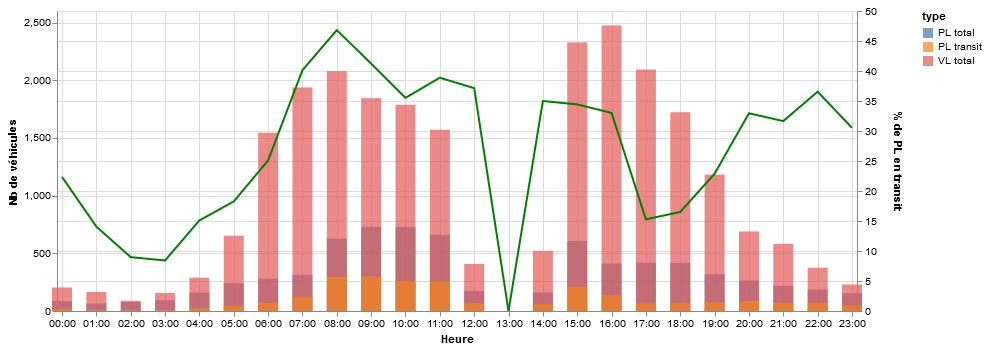

In [52]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-29', 4)

## 7.2 Redressement au niveau de la Rocade

In [126]:
#determiner les passages fictifs
df_passage_transit_redresse, df_pl_redresse, trajets_rocade_non_vu=t.passages_fictif_rocade (t.liste_trajet_rocade, dico_od_final,dico_passag_final,df_pl)
#regrouper
%time synt_nb_veh_cam_redresse=t.pourcentage_pl_camera(df_pl_redresse,df_passage_transit_redresse, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.3 s


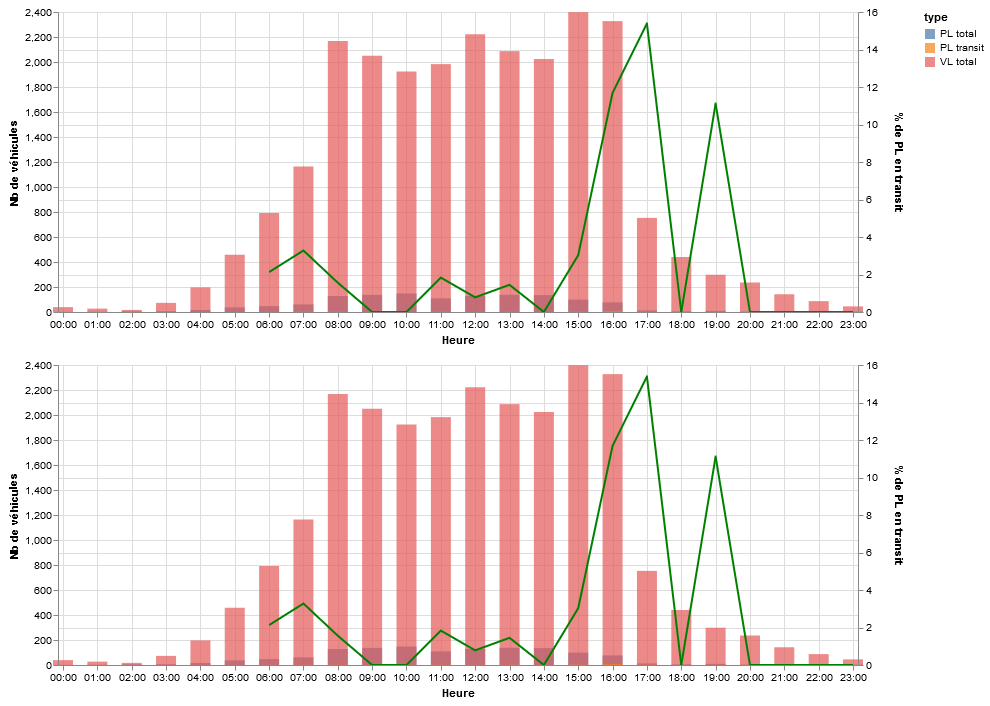

In [46]:
alt.vconcat(g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-28', 1),g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, '2019-01-28', 1))

## 7.3 Redressement des trajets extrapoles

>**A TESTER SUR JEU DE DONNEES COMPLET**

In [ ]:
# de même que opur la rocade, il faut ajouter des passages fictifs à la df des passages afin de pouvoir approximer mieux les parts de PL
#trouver les passages extrapoles
df_od_final.loc[df_od_final['correction_o_d_type']=='extrapole']
# tester la camera de debut :si c'est pas une des cameras d'entree - sortie du dispositif, on sait si le trajet est extrapole en début ou fin
#selon l'o_d crééer un passage fictuf avec le numero de la camera qui manque du trajets sensé avoir eu leiu
#estimer le temps de passage selon le temps theorique : date_cam_1 ou 2 +ou- temps ou temps theorique

## 7.4. Grouper les réusltats par JO

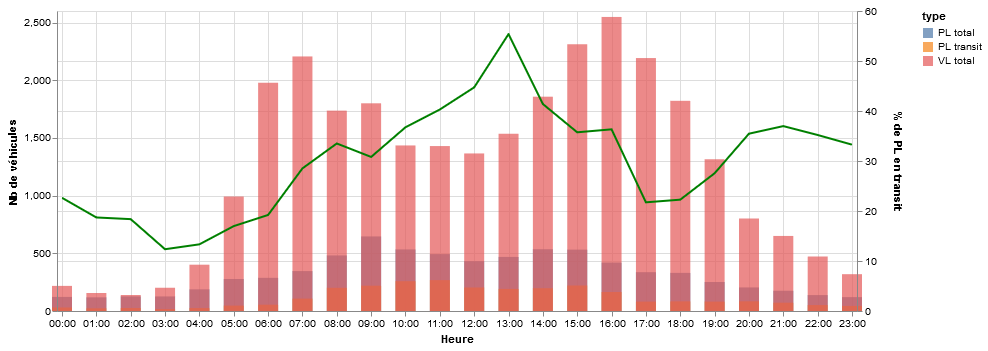

In [133]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, 'JO', 4)

# 8. Temps de parcours

In [26]:
# on cherche à obtenir le temps de parcours moyen pour une camera, sur un jour ou les jours ouvres, par o_d
# on construit donc une df avec : immat, cam, tps_parcours, heure_Rocade
# pour l'heure à la Rocade : on va cehrcher dans les df_passage le passage:qui a la mm immat, dont la cam est 1,2,3,4 et dont le created est compris entre date_cam1et date_cam2

#isoler les passages concernes par la Rocade
passage_rocade=dico_passag_final.loc[(dico_passag_final['camera_id'].isin([1,2,3,4]))]# & (dico_passag_final['correction_o_d']==False)]

In [36]:
#jointure entre les o_d et les passages
o_d_joint_rocade=dico_od_final.merge(passage_rocade, on='immat', how='left')

In [109]:
#limiter les o_d là ou date du passages est ciompris entre les date 1 et date 2 de l'o_d
dico_od_Rocade_final=o_d_joint_rocade.loc[(o_d_joint_rocade['date_cam_1']<o_d_joint_rocade['created']) & 
                                          (o_d_joint_rocade['created']<o_d_joint_rocade['date_cam_2']) & 
                                          (o_d_joint_rocade['tps_parcours']<pd.Timedelta('4H'))]

In [155]:
#limiter les 
limite_donnees=dico_od_Rocade_final[['date_cam_1','immat','o_d','tps_parcours','created']].rename(columns={'created':'h_rocade'})

In [181]:
#filtrer selon une date ou des jours ouvrés ou mardi/jeudi : 
"""filtre_donnees=limite_donnees.loc[(limite_donnees.apply(lambda x : x['h_rocade'].dayofyear==pd.to_datetime('2019-01-28').dayofyear,axis=1)) & 
                          (pour_graph['o_d']=='A10-A62')].copy()"""
filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek<5) & 
                          (limite_donnees['o_d']=='A10-A63')].copy()
"""filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & 
                          (limite_donnees['o_d']=='A10-A62')].copy()"""

"filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & \n                          (limite_donnees['o_d']=='A10-A62')].copy()"

In [182]:
#transformer les valeur de temps en integer pour agregation
filtre_donnees['tps_parcours2']=filtre_donnees['tps_parcours'].values.astype(np.int64)

In [183]:
#mise en forme pour graph
groupe_h=filtre_donnees.set_index('h_rocade').resample('15T')['tps_parcours2'].mean()
#groupe_h['tps_parcours']=pd.to_timedelta(groupe_h['tps_parcours'])
groupe_h=pd.to_timedelta(groupe_h)
pour_graph=groupe_h.reset_index()
pour_graph['tps_parcours2']=pd.to_datetime('2019-01-31')+pour_graph['tps_parcours2']

In [185]:
pour_graph

,h_rocade,tps_parcours2
0,2019-01-28 01:30:00,2019-01-31 01:27:18.000000000
1,2019-01-28 01:45:00,NaT
2,2019-01-28 02:00:00,NaT
3,2019-01-28 02:15:00,2019-01-31 01:35:16.000000000
4,2019-01-28 02:30:00,NaT
5,2019-01-28 02:45:00,2019-01-31 01:11:47.000000000
6,2019-01-28 03:00:00,2019-01-31 01:38:07.000000000
7,2019-01-28 03:15:00,NaT
8,2019-01-28 03:30:00,NaT
9,2019-01-28 03:45:00,NaT


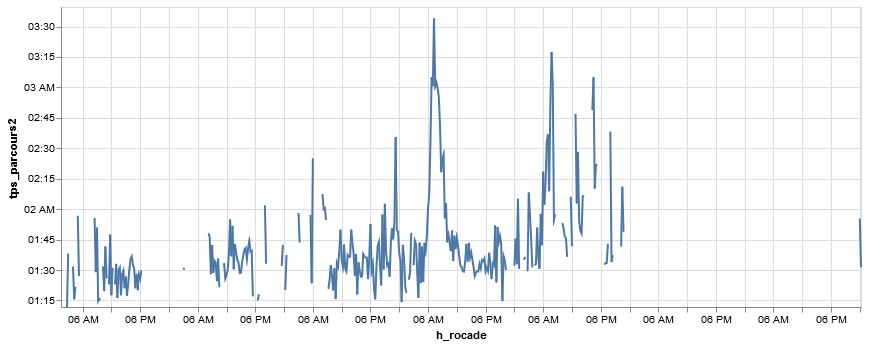

In [184]:
alt.Chart(pour_graph).mark_line().encode(
    x='h_rocade:T',
    y='tps_parcours2').properties(width=800)

In [140]:
dico_od_final.loc[(dico_od_final['o_d']=='A10-A62') & (dico_od_final['date_cam_1']>pd.to_datetime('2019-01-28 21:00'))].sort_values('date_cam_1')

,date_cam_1,index,immat,l,state,id,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,filtre_tps
39342,2019-01-28 22:09:35,1470226,257f094676ed7d7cdd57ceddb8cb8b701f19f56b,1,FR,302358,2019-01-28 22:44:43,"(12, 6, 3, 9)",A10,A62,A10-A62,00:35:08,2019-01-28 22:00,2019-01-28 22:00:00,00:35:08,85eme_percentile,00:37:30.618000,1
16305,2019-01-28 23:54:29,1462459,416963f2dc08205eaccdb2344f05ce0c91c5af90,1,FR,527971,2019-01-29 00:32:45,"(12, 3, 9)",A10,A62,A10-A62,00:38:16,2019-01-28 23:00,2019-01-28 23:00:00,00:38:16,85eme_percentile,00:37:30.618000,1
16306,2019-01-29 01:18:01,1518339,74075d5bfd352363adc505957095b394a20c90d1,1,FR,937887,2019-01-29 01:59:07,"(12, 3, 9)",A10,A62,A10-A62,00:41:06,2019-01-29 01:00,2019-01-29 01:00:00,00:41:06,85eme_percentile,00:37:30.618000,1
51746,2019-01-29 04:29:26,1566388,6b1d13f7fcd523aa44927c0c016e6fa0253b0e03,1,FR,865555,2019-01-29 05:07:01,"(12, 9)",A10,A62,A10-A62,00:37:35,2019-01-29 04:00,2019-01-29 04:00:00,00:38:26.100000,85eme_percentile,00:37:30.618000,1
16307,2019-01-29 04:34:31,1556267,1fe80a61fe87392d17103b5aeed958300dbe260d,1,FR,257669,2019-01-29 05:11:52,"(12, 3, 9)",A10,A62,A10-A62,00:37:21,2019-01-29 04:00,2019-01-29 04:00:00,00:38:26.100000,85eme_percentile,00:37:30.618000,1
50685,2019-01-29 04:50:39,1579378,f1fb586680266e5ef848a455dfac5cdbec6307a5,1,FR,1960162,2019-01-29 05:29:27,"(12, 6, 9)",A10,A62,A10-A62,00:38:48,2019-01-29 04:00,2019-01-29 04:00:00,00:38:26.100000,85eme_percentile,00:37:30.618000,1
39343,2019-01-29 05:25:15,1462454,c4146efc7c3c43fedb56a30994dce3bad17d16e5,1,FR,1587851,2019-01-29 06:13:02,"(12, 6, 3, 9)",A10,A62,A10-A62,00:47:47,2019-01-29 05:00,2019-01-29 05:00:00,00:47:47,85eme_percentile,00:37:30.618000,1
39344,2019-01-29 07:35:01,1556263,03d1dfe1efcd48b5d920eb8d89a6c49047470802,1,FR,30628,2019-01-29 08:46:42,"(12, 6, 3, 9)",A10,A62,A10-A62,01:11:41,2019-01-29 07:30,2019-01-29 07:30:00,01:11:41,Cluster,00:37:30.618000,1
16308,2019-01-29 07:35:04,1593503,1c3f23cdb21394ac0fdc58d5c1fc2ec119ea8536,1,FR,228433,2019-01-29 08:34:17,"(12, 3, 9)",A10,A62,A10-A62,00:59:13,2019-01-29 07:30,2019-01-29 07:30:00,01:11:41,Cluster,00:37:30.618000,1
39345,2019-01-29 07:43:39,1574423,f5490d2e351b080fe5006e5a86517cb59ce21b00,1,FR,1986840,2019-01-29 08:34:06,"(12, 6, 3, 9)",A10,A62,A10-A62,00:50:27,2019-01-29 07:30,2019-01-29 07:30:00,01:11:41,Cluster,00:37:30.618000,1


In [9]:
df_passages

,index,camera_id,immat,fiability,l,state,id
created,,,,,,,
2019-02-08 17:06:35,1982698,8,ffffe549301a252af04ca03d080c70f27d42981a,79,0,,3203972
2019-02-01 13:25:05,3748674,9,ffffe3b1906a9ade77a4b7980f56237cb01b04e5,99,0,FR,3203971
2019-02-01 13:12:12,3810288,2,ffffe3b1906a9ade77a4b7980f56237cb01b04e5,45,0,FR,3203970
2019-02-01 12:41:50,2721830,12,ffffe3b1906a9ade77a4b7980f56237cb01b04e5,99,-1,IT,3203969
2019-02-06 11:39:14,1050141,5,ffffe2b560ce8c126bdb72a77bab10deab471567,44,1,BE,3203969
2019-02-03 09:18:42,926248,5,ffffe2b560ce8c126bdb72a77bab10deab471567,33,-1,BE,3203968
2019-02-01 12:26:42,932564,10,ffffe2b560ce8c126bdb72a77bab10deab471567,34,-1,BE,3203967
2019-02-09 17:20:10,3994773,5,ffffd95f9869dc474136d5a41d11e36f13aa2bff,99,0,FR,3203967
2019-02-09 13:15:52,3999339,6,ffffd95f9869dc474136d5a41d11e36f13aa2bff,99,0,FR,3203966


In [43]:
test_re=df_passages4.reset_index().merge(df_plaques, left_on='immat', right_on='chiffree')

In [45]:
def check_valid_plaque(plque_ouvert, liste_plaque_europ):
    for re_plaque in liste_plaque_europ.re_plaque.tolist() : 
        try :
            if re.search(re_plaque,plque_ouvert) : 
                return True, tuple(liste_plaque_europ.loc[liste_plaque_europ['re_plaque']==re_plaque, 'pays'].tolist())
        except : 
            print(re_plaque,plque_ouvert)
    else : return False, None

In [97]:
def check_valid_plaque(plque_ouvert, liste_plaque_europ):
    if not re.match('^([0-9])+$|^([A-Z])+$',plque_ouvert) :
        return any([re.match(retest,plque_ouvert) for retest in plaques_europ.re_plaque.tolist()])
    else : return False

In [197]:
len(df_passages4)

692674

In [154]:
plaques_europ=pd.read_csv(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\plaques_europ.txt', sep=" ", header=None, names=['pays','re_plaque'])

In [155]:
%%time
validite_pays=test_re.apply(lambda x : check_valid_plaque(x['plaque_ouverte'],plaques_europ),axis=1, result_type='expand')
validite_pays.rename('validite',inplace=True)
valid_plaque=pd.concat([test_re,validite_pays],axis=1, sort=False)

Wall time: 2min 9s


In [160]:
toto=valid_plaque.loc[(~valid_plaque['validite'])].plaque_ouverte.value_counts()
toto.loc[(toto<12) & (toto>1)]

TTTTT         11
ROBERT        11
3362381       11
GRIL0         11
TIT           11
71A           11
WW44          11
REGIS         11
HAUSSN        11
NE            11
YP            11
39RU253       11
ADRIAN        11
HE0MOKING     11
PIRATA        11
A8            11
HONTZA        11
NIV           11
I1III         11
TALIBA        11
RUPL          11
RIT1R         11
ZAZA          11
ANDRIS        11
MIREK         11
303295        11
SI            11
FW            11
ORTUGAL       11
LAGAFF        11
145053        11
SSSSSSSS      11
JEANLUC       11
RNOC3         11
NNNNNNN       11
BOADA         11
90764I33      11
A3            11
DEPANNA0E     11
YJ            11
EPHANE        11
OG1STICS      11
PIT0U         11
O1KINC        11
940X          11
6G1STICS      11
QGISTICS      11
7AW           11
LAPDSTE       10
LUCA          10
ALEXANDRE     10
VNJ           10
GAETAN        10
LU1S          10
0A            10
SARA          10
VIED0         10
DS            10
8XOF          

In [168]:
df_plaques.loc[df_plaques['plaque_ouverte']=='58198II40']

,plaque_ouverte,chiffree
377820,58198II40,b6cd4b737df88935fa302e503746474ac21cecb2


In [169]:
df_passages4.loc[df_passages4['immat']=='b6cd4b737df88935fa302e503746474ac21cecb2']

,index,camera_id,immat,fiability,l,state,id
created,,,,,,,
2019-01-31 01:49:57,2007477,6,b6cd4b737df88935fa302e503746474ac21cecb2,36,1,,2508949
2019-01-31 02:00:33,2013717,3,b6cd4b737df88935fa302e503746474ac21cecb2,57,1,,2508950
2019-01-31 12:19:56,270389,13,b6cd4b737df88935fa302e503746474ac21cecb2,68,1,,2508951
2019-02-07 14:09:34,272524,15,b6cd4b737df88935fa302e503746474ac21cecb2,57,1,,2508952
2019-02-07 14:40:20,2110194,19,b6cd4b737df88935fa302e503746474ac21cecb2,38,1,,2508953
2019-02-09 16:01:22,2065684,12,b6cd4b737df88935fa302e503746474ac21cecb2,68,1,,2508954
2019-02-09 16:15:24,2044710,6,b6cd4b737df88935fa302e503746474ac21cecb2,78,1,,2508955
2019-02-09 16:27:03,2090450,3,b6cd4b737df88935fa302e503746474ac21cecb2,67,1,,2508956
2019-02-09 16:46:08,2105901,18,b6cd4b737df88935fa302e503746474ac21cecb2,78,1,,2508957


In [27]:
t.liste_complete_trajet.loc[t.liste_complete_trajet['o_d']=='A63-A10']

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,11,15,"(15, 19, 4, 5, 11)",A10,120.325213,5,A63-A10,A63,01:30:14.634000
1,11,15,"(15, 19, 1, 5, 11)",A10,125.202188,5,A63-A10,A63,01:33:54.098000
6,11,15,"(15, 19, 1, 11)",A10,125.202188,4,A63-A10,A63,01:33:54.098000
5,11,15,"(15, 19, 4, 11)",A10,120.325213,4,A63-A10,A63,01:30:14.634000
2,11,15,"(15, 4, 5, 11)",A10,120.325213,4,A63-A10,A63,01:30:14.634000
4,11,15,"(15, 19, 5, 11)",A10,120.325213,4,A63-A10,A63,01:30:14.634000
3,11,15,"(15, 1, 5, 11)",A10,125.202188,4,A63-A10,A63,01:33:54.098000
7,11,15,"(15, 4, 11)",A10,120.325213,3,A63-A10,A63,01:30:14.634000
8,11,15,"(15, 1, 11)",A10,125.202188,3,A63-A10,A63,01:33:54.098000
9,11,15,"(15, 5, 11)",A10,120.325213,3,A63-A10,A63,01:30:14.634000


In [39]:
liste_trajet_incomplet

,cam_d,cam_o,cameras,destination,long_km,nb_cams,o_d,origine,tps_parcours_theoriq
0,4,15,"(15, 19, 4)",N10,85.048763,3,A63-N10,A63,01:03:47.194000
14,13,3,"(3, 18, 13)",A63,91.128643,3,A89-A63,A89,01:08:20.788000
38,11,1,"(1, 5, 11)",A10,125.202188,3,A63-A10,A63,01:33:54.098000
1,1,15,"(15, 19, 1)",N10,89.925738,3,A63-N10,A63,01:07:26.658000
36,11,4,"(4, 5, 11)",A10,120.325213,3,A63-A10,A63,01:30:14.634000
34,2,12,"(12, 6, 2)",A63,108.707013,3,A10-A63,A10,01:21:31.815000
7,13,3,"(3, 18, 13)",A63,85.355597,3,N10-A63,N10,01:04:01.001000
9,13,2,"(2, 18, 13)",A63,88.923357,3,N10-A63,N10,01:06:41.551000
32,3,12,"(12, 6, 3)",A63,105.139253,3,A10-A63,A10,01:18:51.266000
12,4,15,"(15, 19, 4)",A89,90.709158,3,A63-A89,A63,01:08:01.912000


In [96]:
re.match('^([0-9])+$|^([A-Z])+$','AA99AA')